# Binary Classification (Horse vs Human)

### Preparing Dataset

In [1]:
# !pip install tensorflow

In [2]:
# !wget --no-check-certificate \
#     https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip \
#     -O Dataset/horse_vs_human.zip

In [3]:
import zipfile
import os

DATASET_ZIP = "Dataset/horse_vs_human.zip"
DATASET = "Dataset/horse_vs_human"

if not os.path.isdir(DATASET):
    os.makedirs(DATASET)
    
    with zipfile.ZipFile(DATASET_ZIP, 'r') as zip_ref:
        zip_ref.extractall(DATASET)
    


## Visualizing some images

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import random

%matplotlib inline

print(f"Available classes of images: {os.listdir(DATASET)}")
def plot_multiple_images(category, rows=3, cols=3):
    req_path = os.path.join(DATASET, category)

    plt.figure()
    f, axs = plt.subplots(rows, cols, figsize=(12, 10))

    for i in range(rows):
        for j in range(cols):
            image = random.choice(os.listdir(req_path))
            img_path = os.path.join(req_path, image)
            img = plt.imread(img_path)
            axs[i, j].title.set_text(image)
            axs[i, j].imshow(img)

Available classes of images: ['humans', 'horses']


<Figure size 432x288 with 0 Axes>

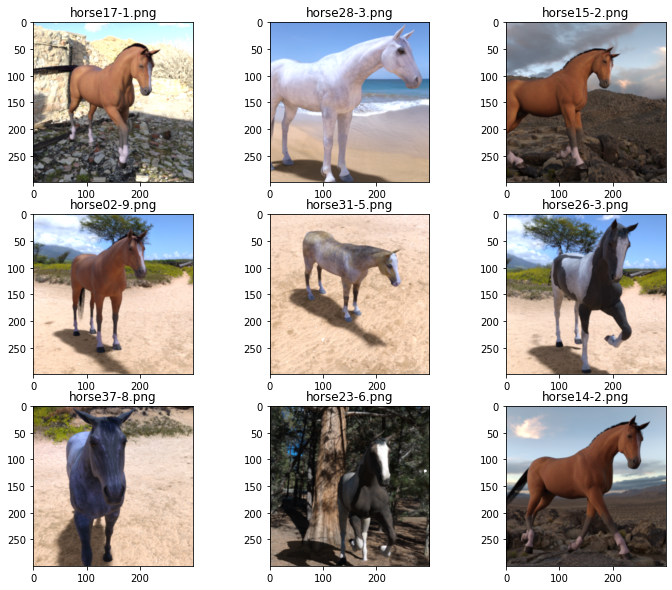

In [6]:
plot_multiple_images('horses')

<Figure size 432x288 with 0 Axes>

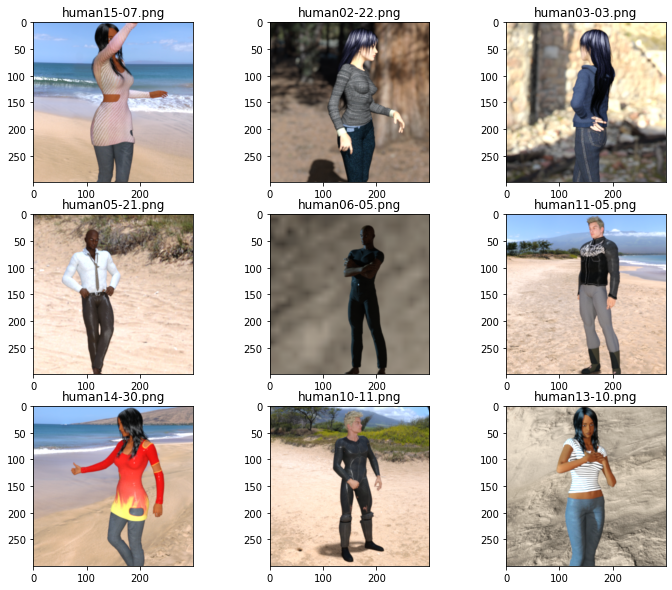

In [7]:
plot_multiple_images('humans')

## Building Model

In [8]:
import tensorflow as tf

In [30]:
def build_model(opt=tf.keras.optimizers.RMSprop(lr=0.001), loss='binary_crossentropy'):
    ## Building
    inputs = tf.keras.Input(shape=(300,300,3))
    x1 = tf.keras.layers.Conv2D(64, (3,3), activation='relu')(inputs)
    x2 = tf.keras.layers.MaxPool2D((2,2))(x1)
    x3 = tf.keras.layers.Conv2D(128, (3,3), activation='relu')(x2)
    x4 = tf.keras.layers.MaxPool2D((2,2))(x3)
    x5 = tf.keras.layers.Flatten()(x4)
    x6 = tf.keras.layers.Dense(256, activation='relu')(x5)
    x7 = tf.keras.layers.Dense(128, activation='relu')(x6)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x7)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs) 
    model.compile(optimizer=opt, loss=loss, metrics=["mae", "acc"])

    return model

In [31]:
## classifier model
model = build_model()

In [32]:
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 300, 300, 3)]     0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 298, 298, 64)      1792      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 149, 149, 64)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 147, 147, 128)     73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 73, 73, 128)       0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 682112)            0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               1746

## Data processing and Generator

In [33]:
train_data_generator = tf.keras.preprocessing.image_dataset_from_directory(
                    directory=DATASET,
                    labels='inferred',
                    label_mode='binary',
                    class_names=["horses", "humans"],
                    batch_size=32,
                    color_mode="rgb",
                    image_size=(300,300),
                    shuffle = True,
                    seed = 1234,
                    validation_split=0.20,
                    subset="training"
                    )

valid_data_generator = tf.keras.preprocessing.image_dataset_from_directory(
                    directory=DATASET,
                    labels='inferred',
                    label_mode='binary',
                    class_names=["horses", "humans"],
                    batch_size=32,
                    color_mode="rgb",
                    image_size=(300,300),
                    shuffle = False,
                    seed = 1234,
                    validation_split=0.20,
                    subset="validation"
                    )

Found 1027 files belonging to 2 classes.
Using 822 files for training.
Found 1027 files belonging to 2 classes.
Using 205 files for validation.


In [34]:
class_names = train_data_generator.class_names
print(f"Label Names: {class_names}")

Label Names: ['horses', 'humans']


In [35]:
train_data_generator.take(1)

<TakeDataset shapes: ((None, 300, 300, 3), (None, 1)), types: (tf.float32, tf.float32)>

In [36]:
## Visualization with Image Generator

/home/raoof/Documents/2021/ml_projects/venv/lib/python3.6/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.


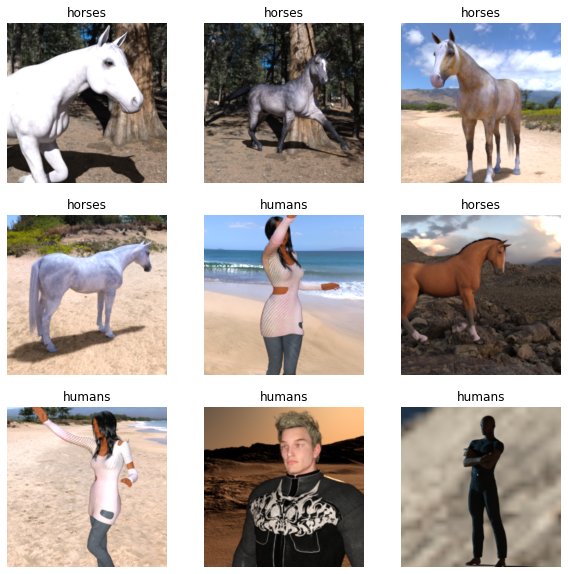

In [37]:
plt.figure(figsize=(10,10))
for images, labels in train_data_generator.take(2):
    for i in range(9):
        ax = plt.subplot(3,3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[int(labels[i].numpy()[0])])
        plt.axis("off")

## Training

In [38]:
## Callnack
class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('acc') > 0.95):
            print("Reached Accuracy. Breaking down")
            self.model.stop_training=True
            
callbacks = MyCallback()

In [39]:
history = model.fit(
            train_data_generator,
            epochs=15,
            verbose=1,
            validation_data=valid_data_generator,
            callbacks=[callbacks]
            )

Epoch 1/15
26/26 [==============================] - 76s 3s/step - loss: 4423.3359 - mae: 0.3410 - acc: 0.6606 - val_loss: 0.0462 - val_mae: 0.0106 - val_acc: 0.9902
Epoch 2/15
26/26 [==============================] - 74s 3s/step - loss: 0.2229 - mae: 0.0210 - acc: 0.9781 - val_loss: 3.3162e-06 - val_mae: 3.3126e-06 - val_acc: 1.0000
Reached Accuracy. Breaking down


## Inference

In [45]:
def predict_image(image_path):
    image = tf.keras.preprocessing.image.load_img(
            image_path, color_mode='rgb', target_size=(300,300))
    
    image_array = np.asarray(image)
    image_array = np.expand_dims(image_array, axis=0)
    out = model.predict(image_array)
    if out < 0.5:
        res = "Horse"
    else:
        res = "Human"
    print(f"Image is: {res}")
    
    

In [48]:
for i, each in enumerate(os.listdir("Dataset/horse_vs_human/humans")):
    req_path = "Dataset/horse_vs_human/humans/" + each
    predict_image(req_path)
    i += 1
    if i > 10:
        break

Image is: Human
Image is: Human
Image is: Human
Image is: Human
Image is: Human
Image is: Human
Image is: Human
Image is: Human
Image is: Human
Image is: Human
Image is: Human


In [49]:
for i, each in enumerate(os.listdir("Dataset/horse_vs_human/horses")):
    req_path = "Dataset/horse_vs_human/horses/" + each
    predict_image(req_path)
    i += 1
    if i > 10:
        break

Image is: Horse
Image is: Horse
Image is: Horse
Image is: Horse
Image is: Horse
Image is: Human
Image is: Horse
Image is: Horse
Image is: Horse
Image is: Horse
Image is: Horse


## Cleanup

In [ ]:
# import os, signal
# os.kill(os.getpid(), signal.SIGKILL)